In [1]:
import cv2
import pydicom
import pandas as pd
import os
import matplotlib.pyplot as plt
import cv2
import numpy as np

In [2]:
# Load the data
path = "./data-sample/train/"
image_paths = [os.path.join(path, f) for f in os.listdir(path)] 

FileNotFoundError: [Errno 2] No such file or directory: './data-sample/train/'

In [19]:
# check resolution of the images
image_shapes = []
for image_path in image_paths:
    image = pydicom.dcmread(image_path)
    image_shapes.append(image.pixel_array.shape)
image_shapes

C:\Users\Amar\Git\xraydetection\venv\lib\site-packages\pydicom\pixel_data_handlers\pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (14-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


[(3072, 3072), (2754, 2332), (2880, 2304), (3072, 3072), (2430, 1994)]

In [21]:
# check max pixel values and bits stored of the images
max_pixel_values = []
bits_stored = []
for image_path in image_paths:
    image = pydicom.dcmread(image_path)
    max_pixel_values.append(image.pixel_array.max())
    bits_stored.append(image.BitsStored)
max_pixel_values, bits_stored

([16383, 16383, 4095, 16383, 4032], [14, 14, 12, 14, 12])

In [22]:
# load the first image
image = pydicom.dcmread(image_paths[1])
image

C:\Users\Amar\Git\xraydetection\venv\lib\site-packages\pydicom\valuerep.py:443: UserWarning: Invalid value for VR UI: '3ffe3bcf96ad33f1d612b24e4a35a38d'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)


Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 166
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: Computed Radiography Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 3ffe3bcf96ad33f1d612b24e4a35a38d
(0002, 0010) Transfer Syntax UID                 UI: JPEG 2000 Image Compression (Lossless Only)
(0002, 0012) Implementation Class UID            UI: 1.2.3.4
(0002, 0013) Implementation Version Name         SH: 'INF_3.9'
(0002, 0016) Source Application Entity Title     AE: 'Samsung'
-------------------------------------------------
(0010, 0040) Patient's Sex                       CS: 'M'
(0010, 1010) Patient's Age                       AS: '033Y'
(0010, 1020) Patient's Size                      DS: '0.0'
(0010, 1030) Patient's Weight                    DS: '0.0'
(0028, 0002) Samples per Pixel                   US: 1
(0028, 0004) Photometric Inter

In [23]:
image.pixel_array.dtype

dtype('uint16')

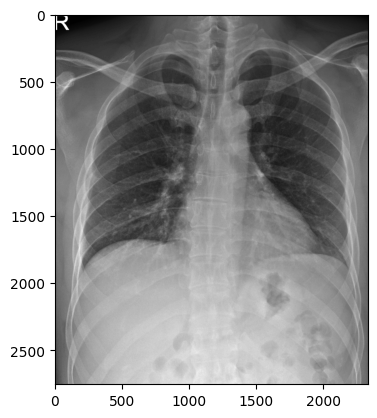

In [24]:
# plot the image
plt.imshow(image.pixel_array, cmap="gray")

In [41]:
image.pixel_array.max()

16383

In [46]:
# rescale the image based on the bits stored to normal pixel range of 0-255
image_rescaled = np.rint((image.pixel_array / 2**image.BitsStored) * 255)
image_rescaled = image_rescaled.astype("uint8")
image_rescaled.max(), image_rescaled.min()

(255, 0)

In [47]:
# resize the image so that the longer side is 640

# check which side is longer
height, width = image_rescaled.shape

if height > width:
    # height must be 640, width will be scaled accordingly
    new_height = 640
    new_width = int(width * (new_height / height))
elif width > height:
    # other way around
    new_width = 640
    new_height = int(height * (new_width / width))
else:
    # square image, resize to 640x640
    new_height = 640
    new_width = 640
image_reshaped = cv2.resize(image_rescaled, (new_width, new_height))

In [48]:
image_rescaled.shape, image_reshaped.shape

((2754, 2332), (640, 541))

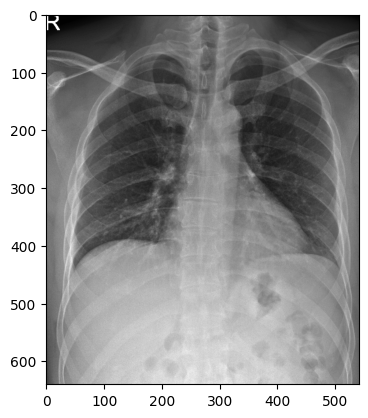

In [49]:
# plot the resized image
plt.imshow(image_reshaped, cmap="gray")

In [50]:
# convert grayscale image to rgb (triple the channels)
image_rgb = cv2.cvtColor(image_reshaped, cv2.COLOR_GRAY2RGB)

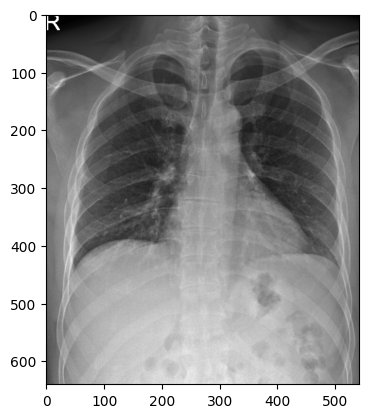

In [51]:
# plot the rgb image
plt.imshow(image_rgb)

In [52]:
# save the image as png
cv2.imwrite("image.png", image_rgb)

True

Preprocessing the annotations

In [53]:
# load the csv file
data = pd.read_csv("./data-sample/train.csv")
data

,image_id,class_name,class_id,rad_id,x_min,y_min,x_max,y_max
0,50a418190bc3fb1ef1633bf9678929b3,No finding,14,R11,NaN,NaN,NaN,NaN
1,21a10246a5ec7af151081d0cd6d65dc9,No finding,14,R7,NaN,NaN,NaN,NaN
2,9a5094b2563a1ef3ff50dc5c7ff71345,Cardiomegaly,3,R10,691.0,1375.0,1653.0,1831.0
3,051132a778e61a86eb147c7c6f564dfe,Aortic enlargement,0,R10,1264.0,743.0,1611.0,1019.0
4,063319de25ce7edb9b1c6b8881290140,No finding,14,R10,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
67909,936fd5cff1c058d39817a08f58b72cae,No finding,14,R1,NaN,NaN,NaN,NaN
67910,ca7e72954550eeb610fe22bf0244b7fa,No finding,14,R1,NaN,NaN,NaN,NaN
67911,aa17d5312a0fb4a2939436abca7f9579,No finding,14,R8,NaN,NaN,NaN,NaN
67912,4b56bc6d22b192f075f13231419dfcc8,Cardiomegaly,3,R8,771.0,979.0,1680.0,1311.0


Outline:
- yolov8 requires one txt file per image with all annotations
- if there are multiple annotations for an image, they should be in the same txt file
- if there are no annotations for an image, no txt file should be produced



In [58]:
# drop all "No finding" rows since no txt file should be produced
annotations = data[data["class_name"] != "No finding"]
annotations

,image_id,class_name,class_id,rad_id,x_min,y_min,x_max,y_max
2,9a5094b2563a1ef3ff50dc5c7ff71345,Cardiomegaly,3,R10,691.0,1375.0,1653.0,1831.0
3,051132a778e61a86eb147c7c6f564dfe,Aortic enlargement,0,R10,1264.0,743.0,1611.0,1019.0
5,1c32170b4af4ce1a3030eb8167753b06,Pleural thickening,11,R9,627.0,357.0,947.0,433.0
6,0c7a38f293d5f5e4846aa4ca6db4daf1,ILD,5,R17,1347.0,245.0,2188.0,2169.0
7,47ed17dcb2cbeec15182ed335a8b5a9e,Nodule/Mass,8,R9,557.0,2352.0,675.0,2484.0
...,...,...,...,...,...,...,...,...
67903,b53d1dd80e99ca6bcef9d592f65d3321,Pleural effusion,10,R9,240.0,1550.0,562.0,2001.0
67906,26d1d5a0ef2e692c6340e74859ffdc53,Pulmonary fibrosis,13,R10,1163.0,787.0,1338.0,941.0
67907,22672ab82c290c20b86863291e25ef6c,ILD,5,R9,299.0,664.0,794.0,1508.0
67908,db169d0be36123bd55b866d6aa73983b,Other lesion,9,R8,6.0,670.0,272.0,1736.0


In [60]:
data["class_name"].unique()

array(['No finding', 'Cardiomegaly', 'Aortic enlargement',
       'Pleural thickening', 'ILD', 'Nodule/Mass', 'Pulmonary fibrosis',
       'Lung Opacity', 'Atelectasis', 'Other lesion', 'Infiltration',
       'Pleural effusion', 'Calcification', 'Consolidation',
       'Pneumothorax'], dtype=object)

In [59]:
# show all class names
annotations["class_name"].unique()

array(['Cardiomegaly', 'Aortic enlargement', 'Pleural thickening', 'ILD',
       'Nodule/Mass', 'Pulmonary fibrosis', 'Lung Opacity', 'Atelectasis',
       'Other lesion', 'Infiltration', 'Pleural effusion',
       'Calcification', 'Consolidation', 'Pneumothorax'], dtype=object)

In [57]:
# group the data by image id
grouped_data = data.groupby("image_id")

# show the first group

,image_id,class_name,class_id,rad_id,x_min,y_min,x_max,y_max
5,1c32170b4af4ce1a3030eb8167753b06,Pleural thickening,11,R9,627.0,357.0,947.0,433.0
2679,1c32170b4af4ce1a3030eb8167753b06,Pulmonary fibrosis,13,R9,511.0,508.0,950.0,762.0
5688,1c32170b4af4ce1a3030eb8167753b06,Pleural thickening,11,R9,1780.0,361.0,2047.0,612.0
15853,1c32170b4af4ce1a3030eb8167753b06,Pulmonary fibrosis,13,R9,1793.0,757.0,1972.0,917.0
21726,1c32170b4af4ce1a3030eb8167753b06,Pulmonary fibrosis,13,R8,1684.0,450.0,1916.0,739.0
47599,1c32170b4af4ce1a3030eb8167753b06,Pulmonary fibrosis,13,R8,549.0,456.0,910.0,801.0
55111,1c32170b4af4ce1a3030eb8167753b06,Pleural thickening,11,R10,1856.0,412.0,2045.0,587.0
61767,1c32170b4af4ce1a3030eb8167753b06,Pulmonary fibrosis,13,R10,529.0,440.0,771.0,741.0
65294,1c32170b4af4ce1a3030eb8167753b06,Pulmonary fibrosis,13,R9,1734.0,545.0,1887.0,747.0


In [61]:
# we will need to adjust the coordinates to fit with the resized image
# for this we need the shape of the original image. As such, we need to iterate through the dicom images

dicom_root = "./data-sample/train/"
dicom_paths = [os.path.join(dicom_root, f) for f in os.listdir(dicom_root)]

In [63]:
for dicom_path in dicom_paths:
    image_id = dicom_path.split("/")[-1].split(".")[0]
    # check if the image has annotations
    if image_id in annotations["image_id"].values:
        image = pydicom.dcmread(dicom_path)
        print(image.pixel_array.shape)